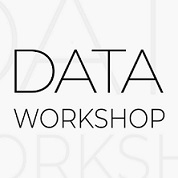

# DWThon 2.0
# by DATA WORKSHOP

## Прогноз цен на автомобили на реальных данных из Польши, используя машинное обучение

###  Хакимуллина Диляра

## Импортирование библиотек 

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from tqdm import tqdm

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import eli5
import re

---

## Далее приведены все функции, которые будут использованы в дальнейшем

In [ ]:
def parse_price(val):
    return float(val.replace(" ", "").replace(",", "."))

In [ ]:
def get_df(df_train, df_test):
    df_train = df_train[ df_train.index != 106447 ].reset_index(drop=True)
    df = pd.concat([df_train, df_test])
 
    params = df["offer_params"].apply(pd.Series)
    params = params.fillna(-1)

    ru_params = ["Безаварийный", "Количество мест", "Страна происхождения",
       "Объем", "Тип топлива", "Коробка передач",
       "Кредит", "Первый владелец", "Предложение от",
       "Количество дверей", "Пробег", "Мощность", "Металлик", "Тип", "Цвет",
       "Модель автомобиля", "Состояние", "Категория", "Обслуживание в сервисном центре", "Привод",
       "Лизинг", "Год выпуска", "Марка автомобиля", "Счет-фактура по НДС",
       "Первая регистрация", "Зарегистрировано в Польше", "Маржа НДС",
       "Версия", "VIN", "Перламутр", "Поврежденный", "Код двигателя",
       "Сажевый фильтр", "Выбросы CO2", "Ежемесячный платеж",
       "Количество оставшихся платежей", "Первоначальный платеж", "Сумма погашения",
       "Акрил (неметаллический)", "Тюнинг", "Правый руль (английский)",
       "Допуск грузовика"]


    dict_params = {pl:ru for pl,ru in zip(params.columns, ru_params)}
    params.rename(columns=dict_params, inplace=True)

    df = pd.concat([df, params], axis=1)
    print(df.shape)

    obj_feats = params.select_dtypes(object).columns

    for feat in obj_feats:
        df["{}_cat".format(feat)] = df[feat].factorize()[0]
            
    return df

In [ ]:
def check_log_model(df, feats, model, cv=5, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

---

## Загрузка данных и их последующее объединение

### Загрузка данных:

In [ ]:
df_train = pd.read_hdf("../input/df.train.h5")
df_train["price_value"] = df_train['price_value'].map(parse_price)

df_test = pd.read_hdf("../input/df.test.h5")


print(df_train.shape, df_test.shape) # вывод параметров датасетов после загрузки

(80129, 10) (80129, 7)


### Конкатенация данных:

In [ ]:
df = get_df(df_train, df_test)

(160257, 86)


### Создание списка категориальных признаков:

In [ ]:
cat_feats = [x for x in df.columns if "_cat" in x] # отбор категориальных призаков по призаку наличия в наименовании столбца "_cat"
cat_feats

['Безаварийный_cat',
 'Количество мест_cat',
 'Страна происхождения_cat',
 'Объем_cat',
 'Тип топлива_cat',
 'Коробка передач_cat',
 'Кредит_cat',
 'Первый владелец_cat',
 'Предложение от_cat',
 'Количество дверей_cat',
 'Пробег_cat',
 'Мощность_cat',
 'Металлик_cat',
 'Тип_cat',
 'Цвет_cat',
 'Модель автомобиля_cat',
 'Состояние_cat',
 'Категория_cat',
 'Обслуживание в сервисном центре_cat',
 'Привод_cat',
 'Лизинг_cat',
 'Год выпуска_cat',
 'Марка автомобиля_cat',
 'Счет-фактура по НДС_cat',
 'Первая регистрация_cat',
 'Зарегистрировано в Польше_cat',
 'Маржа НДС_cat',
 'Версия_cat',
 'VIN_cat',
 'Перламутр_cat',
 'Поврежденный_cat',
 'Код двигателя_cat',
 'Сажевый фильтр_cat',
 'Выбросы CO2_cat',
 'Ежемесячный платеж_cat',
 'Количество оставшихся платежей_cat',
 'Первоначальный платеж_cat',
 'Сумма погашения_cat',
 'Акрил (неметаллический)_cat',
 'Тюнинг_cat',
 'Правый руль (английский)_cat',
 'Допуск грузовика_cat',
 'Make_cat',
 'Metallic_cat',
 'Engine capacity_cat',
 'Version_ca

---

## Тренировка модели на данном этапе

In [ ]:
# Протестируем получившуюся модель на данном этапе (т.е. с теми признаками, которые были в датасете изначально), 
# чтобы получить представление о том, каково значение ошибки (mean_absolute_error) на данный момент,
# и иметь ориентир для дальнейших преобразований модели:

feats = cat_feats
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(11051.872324620412, 311.1903184644602)


Weight,Feature
0.3143,Счет-фактура по НДС_cat
0.0886,Состояние_cat
0.0731,Год выпуска_cat
0.0702,Кредит_cat
0.0676,Коробка передач_cat
0.0507,Привод_cat
0.0490,Обслуживание в сервисном центре_cat
0.0341,Тип_cat
0.0266,Поврежденный_cat
0.0236,Безаварийный_cat


---

## Дополнение модели новыми признаками. Этап 1

### Ведём поиск возможностей для преобразования имеющихся признаков и, тем самым, обогащения  модели новыми признаками

In [ ]:
# Целесообразно будет взглянуть на список имеющихся на данный момент признаков,порассуждать об их сущности,
# и оттолкнуться от этого для формирования гипотез:

list(df.columns)

['id',
 'price_details',
 'price_value',
 'price_currency',
 'features',
 'seller_name',
 'seller_type',
 'seller_address',
 'breadcrumb',
 'offer_params',
 'Безаварийный',
 'Количество мест',
 'Страна происхождения',
 'Объем',
 'Тип топлива',
 'Коробка передач',
 'Кредит',
 'Первый владелец',
 'Предложение от',
 'Количество дверей',
 'Пробег',
 'Мощность',
 'Металлик',
 'Тип',
 'Цвет',
 'Модель автомобиля',
 'Состояние',
 'Категория',
 'Обслуживание в сервисном центре',
 'Привод',
 'Лизинг',
 'Год выпуска',
 'Марка автомобиля',
 'Счет-фактура по НДС',
 'Первая регистрация',
 'Зарегистрировано в Польше',
 'Маржа НДС',
 'Версия',
 'VIN',
 'Перламутр',
 'Поврежденный',
 'Код двигателя',
 'Сажевый фильтр',
 'Выбросы CO2',
 'Ежемесячный платеж',
 'Количество оставшихся платежей',
 'Первоначальный платеж',
 'Сумма погашения',
 'Акрил (неметаллический)',
 'Тюнинг',
 'Правый руль (английский)',
 'Допуск грузовика',
 'Make',
 'Metallic',
 'Engine capacity',
 'Version',
 'VAT discount',
 'No ac

In [ ]:
# Преобразуем данные признака "Год выпуска" в целочисленный тип и получаем новый признак "year_production":
df["year_production"] = df["Год выпуска"].astype(int)

# Поскольку данные признаков "year_production" и "Year" повествуют об одной и той же сущности - годе выпуска автомобиля,
# мы можем произвести дополнение признака "year_production" в тех случаях, когда данные по определенным строкам отсутствуют
# (т.е. когда там находится "-1", которую мы ранее проставили вместо отсутствующих данных), используя данные признака "Year".
# В итоге, в результате обогащения данными, получаем дополненный признак "year_production_ext":
df["year_production_ext"] = df.apply(lambda x: x["year_production"] if x["year_production"] != -1 else int(x["Year"]), axis=1)

In [ ]:
# Извлекаем дополнительные данные, испоьзуя данные признака "Версия".

# Сначала построчно извлекается значение интервала лет (напр., "2010-2015"):
df["version_years"] = df["Версия"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)) )

# Далее извлекается начальное значение из интервала и преобразуется в целочисленный тип:
df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)

# Потом извлекается конечное значение из интервала и преобразуется в целочисленный тип:
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)

---

## Тренировка модели на данном этапе

In [ ]:
# Протестируем получившуюся модель на данном этапе (т.е. добавив к тем признакам, которые были в датасете изначально,
# новые признаки полученные выше).
# Благодаря этому, получим представление о том, каково значение ошибки (mean_absolute_error) на данный момент,
# и сделаем вывод о целесообразности включения призаков в модель:

feats = cat_feats
feats += ["year_production_ext", "version_year_from", "version_year_to"]
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

# Важно добавить, что на практике включение новых призаков происходило поочередно, 
# с последовательной проверкой целесообразности добавления каждого признака.

(9788.190684299854, 305.2152861437874)


Weight,Feature
0.4537,year_production_ext
0.1525,Привод_cat
0.0406,Коробка передач_cat
0.0346,Обслуживание в сервисном центре_cat
0.0282,Поврежденный_cat
0.0255,Тип_cat
0.0245,Счет-фактура по НДС_cat
0.0192,Безаварийный_cat
0.0187,Правый руль (английский)_cat
0.0138,Перламутр_cat


### ! Итак, значение ошибки (mean_absolute_error) уменьшилось в результате включения новых признаков в состав модели примерно на 1263 злотых, следовательно включение новых признаков принесло результаты и было целесообразно.

---

## Дополнение модели новыми признаками. Этап 2

### Продолжаем поиск возможностей для преобразования и дополнения признаков и получения в результате этого процесса новых признаков

In [ ]:
# Взглянем на список имеющихся на данный момент признаков, и оттолкнемся от этого для формирования гипотез.
# Обращаем также внимание на значения (Weights), присвоенные в результате действия eli5:
# это позволяет сделать выводы о признаках, которые оказывают наибольшее влияние, а значит, имеют больший приоритет
# при включении в состав модели.

list(df.columns)

### Признак "Объем"

По результатам последующей оценки прироста ошибки новый признак был впоследствии включён в модель

In [ ]:
df["Объем"]

0         1 199 cm3
1         1 598 cm3
2         1 364 cm3
3         1 798 cm3
4         1 250 cm3
            ...    
160245    2 000 cm3
160246      998 cm3
160247    1 600 cm3
160251    1 560 cm3
160254    3 301 cm3
Name: Объем, Length: 160257, dtype: object

In [ ]:
# Преобразуем данные признака "Объем" в целочисленный тип и получаем новый признак "engine":
df["engine"] = df["Объем"].map(lambda x: str(x).split("cm3")[0].replace(" ", "")).astype("int")

In [ ]:
df["engine"] # видим результаты преобразования

0         1199
1         1598
2         1364
3         1798
4         1250
          ... 
160245    2000
160246     998
160247    1600
160251    1560
160254    3301
Name: engine, Length: 160257, dtype: int32

<AxesSubplot:>

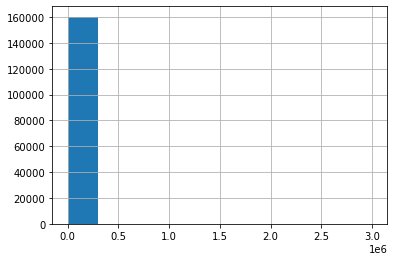

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:
df["engine"].hist()

### Итак, видим, что необходимо решить вопрос о том, как поступить с выбросами (т.к. гистограмма показывает, что имеются аномально большие значения). Заменим на "-1" значения, которые больше 99,7-персентиля (значение подбиралось последовательным подбором и последующим рассмотрением гистограммы. Исходя из того, что нужно и "отсечь" выбросы, и в то же время оставить как можно больше значений признака).

In [ ]:
# Вводится функция для "отсечения" выбросов определенного признака:
def reset_outlires(df, feat, prc=99.7):
    # добавлен параметр для значения персентиля prc,
    # чтобы при необходимости можно было изменять динамически, а не только использовать параметр по умолчанию.
    # Параметром по умолчанию был выбран 99.7, т.к. в результате экспериментов по подбору параметра
    # это значение оказывалось подходящим чаще всего.
    cut_value = np.percentile(df[feat], prc) 
    
    return df[feat].map(lambda x: x if x < cut_value else -1)

<AxesSubplot:>

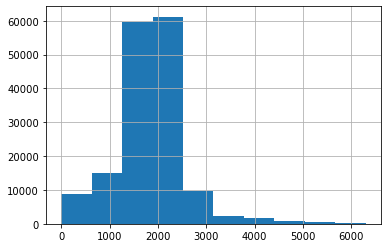

In [ ]:
# Применяем функцию для "отсечения" выбросов и строим гистограмму, чтобы увидеть результат действия функции:
reset_outlires(df, "engine").hist()

In [ ]:
# Присвоим новому признаку "engine_99" значения, полученные после "отсечения" выбросов:
df["engine_99"] = reset_outlires(df, "engine")

### Признак "Мощность"

По результатам последующей оценки прироста ошибки новый признак был впоследствии включён в модель

In [ ]:
df["Мощность"]

0         110 KM
1         117 KM
2          90 KM
3         160 KM
4          82 KM
           ...  
160245    170 KM
160246     69 KM
160247    105 KM
160251     92 KM
160254    174 KM
Name: Мощность, Length: 160257, dtype: object

In [ ]:
# Преобразуем данные признака "Мощность" в целочисленный тип и получаем новый признак "horse_power":
df["horse_power"] = df["Мощность"].map(lambda x: str(x).split("KM")[0].replace(" ", "")).astype("int")

In [ ]:
df["horse_power"] # видим результаты преобразования

0         110
1         117
2          90
3         160
4          82
         ... 
160245    170
160246     69
160247    105
160251     92
160254    174
Name: horse_power, Length: 160257, dtype: int32

<AxesSubplot:>

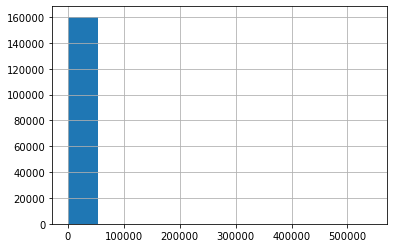

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:
df["horse_power"].hist()

<AxesSubplot:>

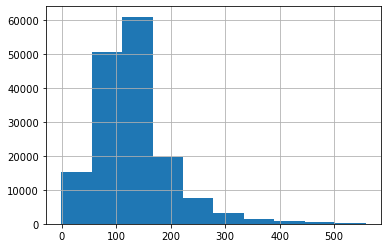

In [ ]:
# Применяем функцию для "отсечения" выбросов и строим гистограмму, чтобы увидеть результат действия функции:
reset_outlires(df, "horse_power").hist()

In [ ]:
# Присвоим новому признаку "horse_power_99" значения, полученные после "отсечения" выбросов:
df["horse_power_99"] = reset_outlires(df, "horse_power")

### Признак "Пробег"

По результатам последующей оценки прироста ошибки новый признак был впоследствии включён в модель

In [ ]:
df["Пробег"]

0             200 km
1         118 808 km
2         106 000 km
3         172 758 km
4          97 128 km
             ...    
160245    109 000 km
160246     40 000 km
160247    132 300 km
160251     76 000 km
160254    208 850 km
Name: Пробег, Length: 160257, dtype: object

In [ ]:
# Преобразуем данные признака "Пробег" в целочисленный тип и получаем новый признак "mileage_new"
# (использована подпись "new" во избежание разночтений, т.к. в датасете уже есть ещё один признак "Mileage"):
df["mileage_new"] = df["Пробег"].map(lambda x: str(x).split("km")[0].replace(" ", "")).astype("int")

In [ ]:
df["mileage_new"] # видим результаты преобразования

0            200
1         118808
2         106000
3         172758
4          97128
           ...  
160245    109000
160246     40000
160247    132300
160251     76000
160254    208850
Name: mileage_new, Length: 160257, dtype: int32

<AxesSubplot:>

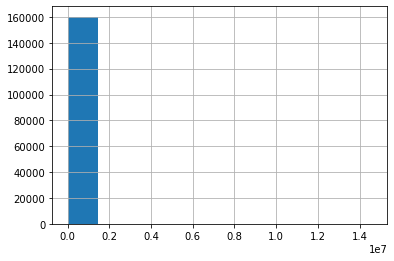

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:
df["mileage_new"].hist()

<AxesSubplot:>

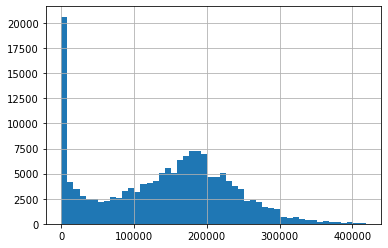

In [ ]:
# Применяем функцию для "отсечения" выбросов и строим гистограмму, чтобы увидеть результат действия функции:
reset_outlires(df, "mileage_new").hist(bins = 50)

In [ ]:
# Присвоим новому признаку "mileage_new_99" значения, полученные после "отсечения" выбросов:
df["mileage_new_99"] = reset_outlires(df, "mileage_new")

### Признак "Количество оставшихся платежей"

По результатам последующей оценки прироста ошибки новый признак был впоследствии включён в модель

In [ ]:
df["Количество оставшихся платежей"]

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
160245    -1
160246    -1
160247    -1
160251    -1
160254    -1
Name: Количество оставшихся платежей, Length: 160257, dtype: object

In [ ]:
# Поскольку при просмотре признака на предыдущем шаге не смогли получить первичного представления о том,
# какими значениями представлен признак (много отсутствующих значений, заменённых ранее на "-1"),
# попробуем взглянуть на него в другом разрезе - уникальных значений и их количества:
df["Количество оставшихся платежей"].value_counts()

-1          159814
36              81
48              30
60              24
47              21
             ...  
68               1
4                1
56               1
3 482,92         1
77               1
Name: Количество оставшихся платежей, Length: 70, dtype: int64

In [ ]:
# Преобразуем данные признака "Количество оставшихся платежей" в целочисленный тип 
# и получаем новый признак "number_of_remaining_payments":

df["number_of_remaining_payments"] = df["Количество оставшихся платежей"].map(lambda x: str(x).split()[0].\
                                                                              replace(" ", "")).astype("int")

In [ ]:
df["number_of_remaining_payments"].value_counts() # видим результаты преобразования

-1     159814
 36        81
 48        30
 60        24
 47        21
        ...  
 77         1
 4          1
 39         1
 2          1
 68         1
Name: number_of_remaining_payments, Length: 68, dtype: int64

<AxesSubplot:>

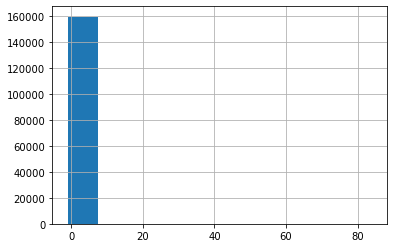

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:

df["number_of_remaining_payments"].hist()

<AxesSubplot:>

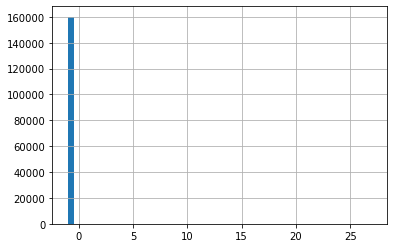

In [ ]:
# Применяем функцию для "отсечения" выбросов и строим гистограмму, чтобы увидеть результат действия функции:

reset_outlires(df, "number_of_remaining_payments", prc=99.8).hist(bins = 50)

<AxesSubplot:>

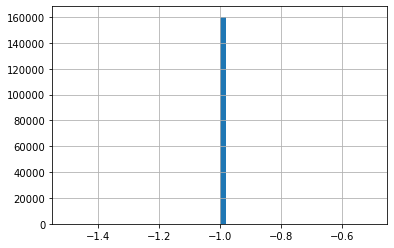

In [ ]:
# !В результате был сделан вывод о том, что не стоит отсекать выбросы при значении персентиля менее, чем 99,8.
# Иначе, если мы отсечём выбросы при персентиле менее, чем 99.8, 
# то в составе признака останутся только значения "-1", т.е. отсутствующие, 
# и это не будет иметь никакого смысла. Более целесообразно сохранить имеющиеся значения, т.к. они и так немногочисленны.
# Проиллюстрируем это на гистограмме (остались лишь отсутствующие значения).

reset_outlires(df, "number_of_remaining_payments", prc=99.7).hist(bins = 50)

In [ ]:
# Присвоим новому признаку "number_of_remaining_payments_99" значения, полученные после "отсечения" выбросов:
df["number_of_remaining_payments_99"] = reset_outlires(df, "number_of_remaining_payments", prc=99.8)

### Признак "Ежемесячный платеж"

По результатам последующей оценки прироста ошибки новый признак был впоследствии включён в модель

In [ ]:
df["Ежемесячный платеж"]

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
160245    -1
160246    -1
160247    -1
160251    -1
160254    -1
Name: Ежемесячный платеж, Length: 160257, dtype: object

In [ ]:
# Поскольку при просмотре признака на предыдущем шаге не смогли получить первичного представления о том,
# какими значениями представлен признак (много отсутствующих значений, заменённых ранее на "-1"),
# попробуем взглянуть на него в другом разрезе - уникальных значений и их количества:

df["Ежемесячный платеж"].value_counts()

-1           159531
400 PLN          27
600 PLN          21
500 PLN          15
700 PLN          13
              ...  
1 701 PLN         1
734 PLN           1
778 PLN           1
761 PLN           1
4 100 PLN         1
Name: Ежемесячный платеж, Length: 534, dtype: int64

In [ ]:
# Преобразуем данные признака "Ежемесячный платеж" в тип данных чисел с плавающей точкой
# и получаем новый признак "monthly_payment":

df["monthly_payment"] = df["Ежемесячный платеж"].map(lambda x: str(x).split("PLN")[0].replace(" ", "").\
                                                     replace(",", ".")).astype("float")

In [ ]:
df["monthly_payment"].value_counts() # видим результаты преобразования

-1.000      159531
400.000         27
600.000         21
500.000         15
700.000         13
             ...  
3734.000         1
4378.210         1
1870.000         1
3440.000         1
1776.770         1
Name: monthly_payment, Length: 534, dtype: int64

<AxesSubplot:>

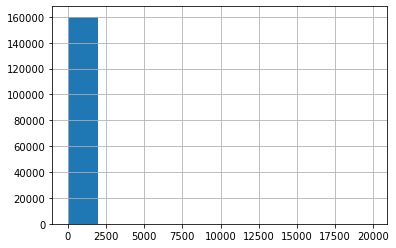

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:

df["monthly_payment"].hist()

<AxesSubplot:>

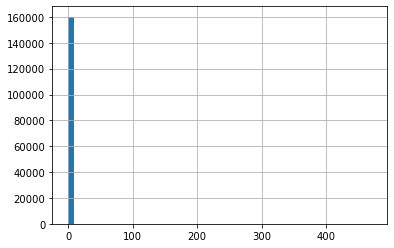

In [ ]:
# Применяем функцию для "отсечения" выбросов и строим гистограмму, чтобы увидеть результат действия функции:

reset_outlires(df, "monthly_payment", prc=99.6).hist(bins = 50)

<AxesSubplot:>

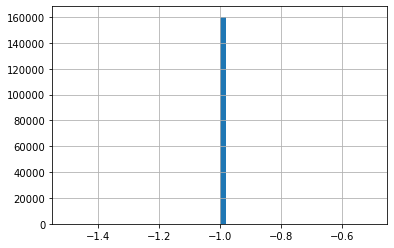

In [ ]:
# !В результате был сделан вывод о том, что не стоит отсекать выбросы при значении персентиля менее, чем 99,6.
# Иначе, если мы отсечём выбросы при персентиле менее, чем 99.6, 
# то в составе признака останутся только значения "-1", т.е. отсутствующие, 
# и это не будет иметь никакого смысла. Более целесообразно сохранить имеющиеся значения, т.к. они и так немногочисленны.
# Проиллюстрируем это на гистограмме (остались лишь отсутствующие значения).

reset_outlires(df, "number_of_remaining_payments", prc=99.5).hist(bins = 50)

In [ ]:
# Присвоим новому признаку "monthly_payment_99" значения, полученные после "отсечения" выбросов:

df["monthly_payment_99"] = reset_outlires(df, "monthly_payment", prc=99.6)

### Признак "Сумма погашения"

По результатам последующей оценки прироста ошибки новый признак был впоследствии включён в модель

In [ ]:
df["Сумма погашения"]

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
160245    -1
160246    -1
160247    -1
160251    -1
160254    -1
Name: Сумма погашения, Length: 160257, dtype: object

In [ ]:
# Поскольку при просмотре признака на предыдущем шаге не смогли получить первичного представления о том,
# какими значениями представлен признак (много отсутствующих значений, заменённых ранее на "-1"),
# попробуем взглянуть на него в другом разрезе - уникальных значений и их количества:

df["Сумма погашения"].value_counts()

-1                159849
1 PLN                 15
1 000 PLN              6
50 000 PLN             3
30 000 PLN             3
                   ...  
11 000 PLN             1
1 271 PLN              1
1 159 PLN              1
51 900 PLN             1
118 406,76 PLN         1
Name: Сумма погашения, Length: 355, dtype: int64

In [ ]:
# Преобразуем данные признака "Сумма погашения" в тип данных чисел с плавающей точкой
# и получаем новый признак "amount_to_pay":

df["amount_to_pay"] = df["Сумма погашения"].map(lambda x: str(x).split("PLN")[0].replace(" ", "").\
                                                replace(",", ".")).astype("float")

In [ ]:
df["amount_to_pay"].value_counts() # видим результаты преобразования

-1.000       159849
1.000            15
1000.000          6
87857.000         3
30000.000         3
              ...  
794.680           1
88015.220         1
14940.000         1
30617.890         1
20340.000         1
Name: amount_to_pay, Length: 355, dtype: int64

<AxesSubplot:>

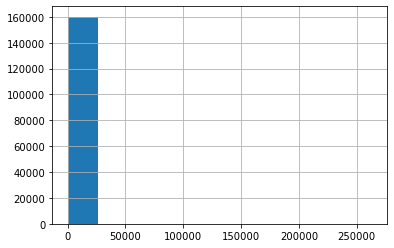

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:

df["amount_to_pay"].hist()

<AxesSubplot:>

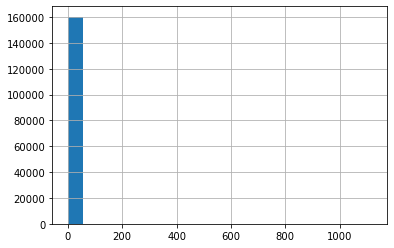

In [ ]:
# Применяем функцию для "отсечения" выбросов и строим гистограмму, чтобы увидеть результат действия функции:

reset_outlires(df, "amount_to_pay", prc=99.8).hist(bins = 20)

<AxesSubplot:>

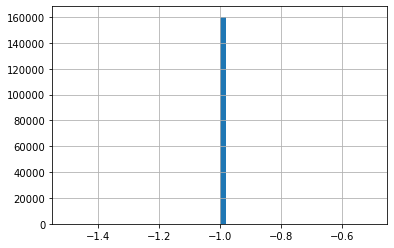

In [ ]:
# !В результате был сделан вывод о том, что не стоит отсекать выбросы при значении персентиля менее, чем 99,8.
# Иначе, если мы отсечём выбросы при персентиле менее, чем 99.8, 
# то в составе признака останутся только значения "-1", т.е. отсутствующие, 
# и это не будет иметь никакого смысла. Более целесообразно сохранить имеющиеся значения, т.к. они и так немногочисленны.
# Проиллюстрируем это на гистограмме (остались лишь отсутствующие значения).

reset_outlires(df, "number_of_remaining_payments", prc=99.7).hist(bins = 50)

In [ ]:
# Присвоим новому признаку "amount_to_pay_99" значения, полученные после "отсечения" выбросов:

df["amount_to_pay_99"] = reset_outlires(df, "amount_to_pay", prc=99.8)

### Признак "Первоначальный платеж"

По результатам последующей оценки прироста ошибки новый признак был впоследствии включён в модель

In [ ]:
df["Первоначальный платеж"]

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
160245    -1
160246    -1
160247    -1
160251    -1
160254    -1
Name: Первоначальный платеж, Length: 160257, dtype: object

In [ ]:
# Поскольку при просмотре признака на предыдущем шаге не смогли получить первичного представления о том,
# какими значениями представлен признак (много отсутствующих значений, заменённых ранее на "-1"),
# попробуем взглянуть на него в другом разрезе - уникальных значений и их количества:

df["Первоначальный платеж"].value_counts()

-1               159844
1 PLN                31
15 000 PLN           13
20 000 PLN           12
5 000 PLN             8
                  ...  
14 199 PLN            1
65 040,23 PLN         1
21 597 PLN            1
20 719 PLN            1
900 000 PLN           1
Name: Первоначальный платеж, Length: 259, dtype: int64

In [ ]:
# Преобразуем данные признака "Первоначальный платеж" в тип данных чисел с плавающей точкой
# и получаем новый признак "first_payment":

df["first_payment"] = df["Первоначальный платеж"].map(lambda x: str(x).split("PLN")[0].\
                                                      replace(" ", "").replace(",", ".")).astype("float")

In [ ]:
df["first_payment"].value_counts() # видим результаты преобразования

-1.000        159844
1.000             31
15000.000         13
20000.000         12
5000.000           8
               ...  
20325.000          1
14199.000          1
4000.000           1
28353.000          1
111000.000         1
Name: first_payment, Length: 259, dtype: int64

<AxesSubplot:>

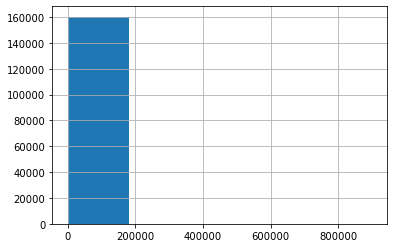

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:

df["first_payment"].hist(bins = 5)

<AxesSubplot:>

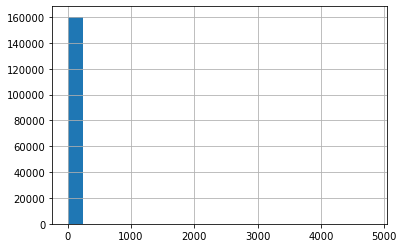

In [ ]:
# Применяем функцию для "отсечения" выбросов и строим гистограмму, чтобы увидеть результат действия функции:

reset_outlires(df, "first_payment", prc=99.8).hist(bins = 20)

<AxesSubplot:>

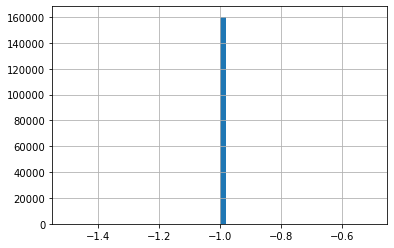

In [ ]:
# !В результате был сделан вывод о том, что не стоит отсекать выбросы при значении персентиля менее, чем 99,8.
# Иначе, если мы отсечём выбросы при персентиле менее, чем 99.8, 
# то в составе признака останутся только значения "-1", т.е. отсутствующие, 
# и это не будет иметь никакого смысла. Более целесообразно сохранить имеющиеся значения, т.к. они и так немногочисленны.
# Проиллюстрируем это на гистограмме (остались лишь отсутствующие значения).

reset_outlires(df, "number_of_remaining_payments", prc=99.7).hist(bins = 50)

In [ ]:
# Присвоим новому признаку "first_payment_99" значения, полученные после "отсечения" выбросов:

df["first_payment_99"] = reset_outlires(df, "first_payment", prc=99.8)

---

### Признак "Количество дверей"

! Важно отметить, что по результатам последующей оценки прироста ошибки новый полученный признак впоследствии НЕ БЫЛ включён в модель, т.к. его включение приводило уже к увеличению значения ошибки

In [ ]:
df["Количество дверей"]

0          5
1          5
2          3
3          5
4          5
          ..
160245    -1
160246     5
160247     5
160251     5
160254     5
Name: Количество дверей, Length: 160257, dtype: object

In [ ]:
# Посмотрим на данные также в разрезе уникальных значений и соответствующего им количества:

df["Количество дверей"].value_counts()

5     107551
4      22867
-1     14743
3      11010
2       3905
6        144
7         18
9          6
8          6
1          6
30         1
Name: Количество дверей, dtype: int64

In [ ]:
# Преобразуем данные признака "Количество дверей" в целочисленный тип 
# и получаем новый признак "doors_number":

df["doors_number"] = df["Количество дверей"].map(lambda x: str(x).split()[0].replace(" ", "")).astype("int")

In [ ]:
df["doors_number"] # видим результаты преобразования

0         5
1         5
2         3
3         5
4         5
         ..
160245   -1
160246    5
160247    5
160251    5
160254    5
Name: doors_number, Length: 160257, dtype: int32

In [ ]:
df["doors_number"].value_counts() # видим результаты преобразования

 5     107551
 4      22867
-1      14743
 3      11010
 2       3905
 6        144
 7         18
 9          6
 8          6
 1          6
 30         1
Name: doors_number, dtype: int64

<AxesSubplot:>

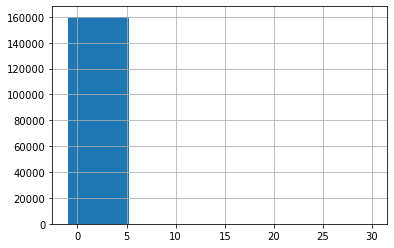

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:

df["doors_number"].hist(bins = 5)

<AxesSubplot:>

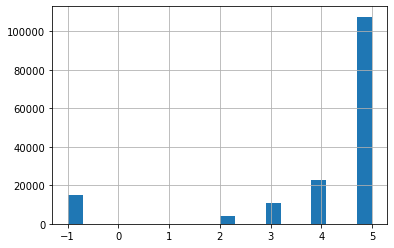

In [ ]:
# Применяем функцию для "отсечения" выбросов и строим гистограмму, чтобы увидеть результат действия функции:

reset_outlires(df, "doors_number", prc=99.9).hist(bins = 20)

In [ ]:
# Присвоим новому признаку "doors_number_99" значения, полученные после "отсечения" выбросов 
# (НЕ БУДЕТ ИСПОЛЬЗОВАН В ИТОГЕ):

df["doors_number_99"] = reset_outlires(df, "doors_number", prc=99.9)

### Признаки "horse_power_99" и "Engine power"
### (дополнение значений признака "horse_power_99" значениями признака "Engine power")

Поскольку значения и того, и другого признака описывают одну и ту же сущность - мощность в лошадиных силах, было принято решение о целесообразности объединения.

По результатам последующей оценки прироста ошибки новый полученный признак (дополненный) впоследствии был включён в модель

In [ ]:
# Прежде уделим внимание признаку "Engine power" и проведём необходимые преобразования
# (признак "horse_power_99" рассматривался выше):

In [ ]:
df["Engine power"]

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
160245    -1
160246    -1
160247    -1
160251    -1
160254    -1
Name: Engine power, Length: 160257, dtype: object

In [ ]:
# Посмотрим на данные также в разрезе уникальных значений и соответствующего им количества:

df["Engine power"].value_counts()

-1        160142
140 HP         9
150 HP         9
90 HP          6
116 HP         6
105 HP         5
190 HP         5
110 HP         5
100 HP         5
136 HP         4
120 HP         4
75 HP          4
147 HP         3
177 HP         3
115 HP         3
180 HP         3
163 HP         3
102 HP         3
95 HP          2
192 HP         2
170 HP         2
218 HP         2
126 HP         2
160 HP         2
130 HP         2
109 HP         2
161 HP         1
173 HP         1
80 HP          1
83 HP          1
188 HP         1
204 HP         1
305 HP         1
60 HP          1
233 HP         1
184 HP         1
127 HP         1
117 HP         1
67 HP          1
70 HP          1
72 HP          1
77 HP          1
143 HP         1
455 HP         1
65 HP          1
Name: Engine power, dtype: int64

In [ ]:
# Преобразуем данные признака "Engine power" в целочисленный тип 
# и получаем новый признак "Engine_power_2":

df["Engine_power_2"] = df["Engine power"].map(lambda x: str(x).split("HP")[0].replace(" ", "")).astype("int")

In [ ]:
df["Engine_power_2"] # видим результаты преобразования

0        -1
1        -1
2        -1
3        -1
4        -1
         ..
160245   -1
160246   -1
160247   -1
160251   -1
160254   -1
Name: Engine_power_2, Length: 160257, dtype: int32

In [ ]:
df["Engine_power_2"].value_counts() # видим результаты преобразования

-1      160142
 150         9
 140         9
 116         6
 90          6
 110         5
 190         5
 100         5
 105         5
 136         4
 120         4
 75          4
 115         3
 102         3
 180         3
 163         3
 147         3
 177         3
 192         2
 170         2
 130         2
 160         2
 218         2
 95          2
 109         2
 126         2
 161         1
 143         1
 173         1
 305         1
 127         1
 184         1
 60          1
 188         1
 65          1
 67          1
 70          1
 72          1
 204         1
 77          1
 80          1
 83          1
 233         1
 117         1
 455         1
Name: Engine_power_2, dtype: int64

<AxesSubplot:>

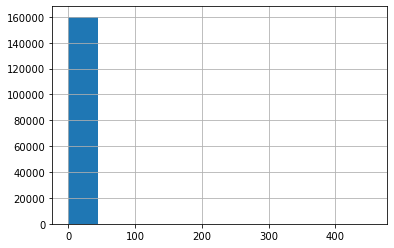

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:

df["Engine_power_2"].hist()

! Было принято решение не "отсекать" выбросы, т.к. для признака "horse_power_99", с которым предстоит объединение, значения в районе 400 не являются аномальными.

In [ ]:
# Посмотрим, как признак "Engine_power_2" может дополнить признак "horse_power_99" 
# (видим, что есть дополнения в случаях, когда значения у признака "horse_power_99" равны "-1", т.е. отсутствуют):

pd.crosstab(df.horse_power_99, df.Engine_power_2)

Engine_power_2,-1,60,65,67,70,72,75,77,80,83,90,95,100,102,105,109,110,115,116,117,120,126,127,130,136,140,143,147,150,160,161,163,170,173,177,180,184,188,190,192,204,218,233,305,455
horse_power_99,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,14460,1,1,1,1,1,4,1,1,1,6,2,5,3,5,2,5,3,6,1,4,2,1,2,4,9,1,3,9,2,1,3,2,1,3,3,1,1,5,2,1,2,1,1,1
1,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
551,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
555,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Итак, можем произвести дополнение признака "horse_power_99" в тех случаях, когда данные по определенным строкам отсутствуют
# (т.е. когда там находится "-1", которую мы ранее проставили вместо отсутствующих данных), 
# используя данные признака "Engine_power_2".
# В итоге, в результате обогащения данными, получаем дополненный признак "horse_power_99_ext":

df["horse_power_99_ext"] = df.apply(lambda x: x["horse_power_99"] if x["horse_power_99"] != -1 else \
                                    int(x["Engine_power_2"]), axis=1)

In [ ]:
# Можем увидеть количество отсутствующих значений, заменённых на "-1", до дополнения призака "horse_power_99":

df[ df["horse_power_99"] == -1 ].shape

(14575, 185)

In [ ]:
# Можем увидеть количество отсутствующих значений, заменённых на "-1", после дополнения призака "horse_power_99":

df[ df["horse_power_99_ext"] == -1 ].shape 

(14460, 185)

! Как видим, количество пропусков уменьшилось, а значит, дополнение признака было целесообразным.

---

### Признаки "mileage_new_99" и "Mileage"
### (дополнение значений признака "mileage_new_99" значениями признака "Mileage")

Поскольку значения и того, и другого признака описывают одну и ту же сущность - пробег автомобиля в километрах, было принято решение о целесообразности объединения.

!!! Однако по результатам последующей оценки прироста ошибки новый полученный признак (дополненный) впоследствии НЕ БЫЛ включён в модель, т.к. его включение приводило уже к увеличению значения ошибки.

In [ ]:
# Прежде уделим внимание признаку "Mileage" и проведём необходимые преобразования
# (признак "mileage_new_99" рассматривался выше):

In [ ]:
df["Mileage"]

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
160245    -1
160246    -1
160247    -1
160251    -1
160254    -1
Name: Mileage, Length: 160257, dtype: object

In [ ]:
# Поскольку при просмотре признака на предыдущем шаге не смогли получить первичного представления о том,
# какими значениями представлен признак (много отсутствующих значений, заменённых ранее на "-1"),
# попробуем взглянуть на него в другом разрезе - уникальных значений и их количества:

df["Mileage"].value_counts()

-1            160130
1 km               3
207 000 km         3
210 000 km         3
189 000 km         2
               ...  
3 km               1
28 422 km          1
130 000 km         1
242 000 km         1
199 000 km         1
Name: Mileage, Length: 116, dtype: int64

In [ ]:
# Преобразуем данные признака "Mileage" в целочисленный тип 
# и получаем новый признак "Mileage_new_2":

df["Mileage_new_2"] = df["Mileage"].map(lambda x: str(x).split("km")[0].replace(" ", "")).astype("int")

In [ ]:
df["Mileage_new_2"].value_counts() # видим результаты преобразования

-1         160130
 207000         3
 1              3
 210000         3
 177000         2
            ...  
 56902          1
 20436          1
 268000         1
 100            1
 184025         1
Name: Mileage_new_2, Length: 116, dtype: int64

<AxesSubplot:>

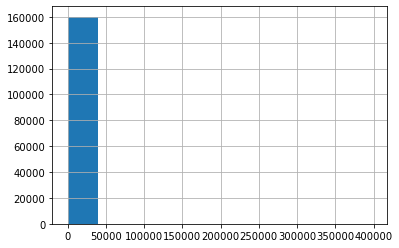

In [ ]:
# Посмотрим на распределение признака, используя визуализацию - гистограмму:

df["Mileage_new_2"].hist() # не отсекаем выбросы, т.к. 400 000 для "mileage_new" не выглядело как выбросы

! Было принято решение не "отсекать" выбросы, т.к. для признака "mileage_new", с которым предстоит объединение, значения в районе 400 000 не являются аномальными.

In [ ]:
# Посмотрим, как признак "Mileage_new_2" может дополнить признак "mileage_new_99" 
# (видим, что есть дополнения в случаях, когда значения у признака "mileage_new_99" равны "-1", т.е. отсутствуют):

pd.crosstab(df.mileage_new_99, df.Mileage_new_2)

Mileage_new_2,-1,1,2,3,5,9,10,100,3000,3200,4000,6202,8336,9500,10297,13000,16000,18000,20000,20436,22000,25000,26000,28422,30000,34400,45550,46569,48000,54000,56902,57000,64000,66398,71700,79000,82000,91500,95000,97300,98000,99000,107000,110000,112000,122300,123000,123900,130000,135233,135608,136000,136125,140000,144000,145000,149000,150000,151000,152887,159000,161214,164665,166900,168000,169000,170000,172000,175000,177000,178564,178900,181000,184025,185000,189000,191000,192800,194000,194100,195000,197000,199000,202558,202600,204557,206000,207000,210000,216749,217000,223000,225740,228000,230786,232159,233000,238000,241000,242000,242194,243000,245506,248428,258000,262000,268000,272000,281000,284532,310000,317000,372000,375000,381000,398000
mileage_new_99,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,897,3,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,3,3,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,669,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
417006,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
417100,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Посмотрим и в другом разрезе, как признак "Mileage_new_2" может дополнить признак "mileage_new_99"
# (видим, что есть дополнения в случаях, когда значения у признака "mileage_new_99" равны "-1", т.е. отсутствуют):

df[ df.mileage_new_99 == -1 ][["mileage_new_99", "Mileage_new_2"]]

,mileage_new_99,Mileage_new_2
11,-1,-1
314,-1,122300
420,-1,-1
466,-1,123900
601,-1,262000
...,...,...
158687,-1,-1
159471,-1,-1
159693,-1,-1
159820,-1,-1


In [ ]:
# Итак, можем произвести дополнение признака "mileage_new_99" в тех случаях, когда данные по определенным строкам отсутствуют
# (т.е. когда там находится "-1", которую мы ранее проставили вместо отсутствующих данных), 
# используя данные признака "Mileage_new_2".
# В итоге, в результате обогащения данными, получаем дополненный признак "mileage_new_99_ext":

df["mileage_new_99_ext"] = df.apply(lambda x: x["mileage_new_99"] if x["mileage_new_99"] != -1 else \
                                    int(x["Mileage_new_2"]), axis=1)

In [ ]:
# Можем увидеть количество отсутствующих значений, заменённых на "-1", до дополнения призака "mileage_new_99":

df[ df["mileage_new_99"] == -1 ].shape

(1024, 187)

In [ ]:
# Можем увидеть количество отсутствующих значений, заменённых на "-1", после дополнения призака "mileage_new_99":

df[ df["mileage_new_99_ext"] == -1 ].shape 

(897, 187)

! Как видим, количество пропусков уменьшилось, а значит, дополнение признака было целесообразным.
Но новый полученный признак (дополненный) впоследствии НЕ БЫЛ включён в модель, т.к. его включение приводило уже к увеличению значения ошибки.

---

## Тестирование модели на заключительном этапе 

In [ ]:
# Протестируем получившуюся модель на данном заключительном этапе 
# (добавляя к тем признакам, которые были в датасете изначально, НОВЫЕ признаки полученные выше).
# Благодаря этому, получим представление о том, каково значение ошибки (mean_absolute_error) на данный момент,
# и сделаем вывод о целесообразности окончательного включения призаков в модель:

feats.clear() # действия для предотвращения многократной записи одних и тех же признаков в список feats
cat_feats = [x for x in df.columns if "_cat" in x]
feats = cat_feats

feats += ["year_production_ext", "version_year_from", "version_year_to", \
          "engine_99", "horse_power_99_ext", "mileage_new_99", \
          "number_of_remaining_payments_99", "monthly_payment_99", "amount_to_pay_99", "first_payment_99"]

check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

# Важно добавить, что на практике включение новых призаков происходило поочередно, 
# с последовательной проверкой целесообразности добавления каждого признака.

(8574.289272963613, 140.4766549522986)


Weight,Feature
0.3892,year_production_ext
0.1288,Привод_cat
0.0936,horse_power_99_ext
0.0844,Коробка передач_cat
0.0444,Обслуживание в сервисном центре_cat
0.0286,Поврежденный_cat
0.0212,engine_99
0.0205,Правый руль (английский)_cat
0.0189,Тип_cat
0.0165,Безаварийный_cat


### ! Итак, значение ошибки (mean_absolute_error) уменьшилось в результате включения новых признаков в состав модели примерно на 1214 злотых (по сравнению с предыдущим этапом, когда были включены только новые признаки "year_production_ext", "version_year_from", "version_year_to"), следовательно включение других новых признаков было целесообразным.

---

### !!! Важно отметить, что при тестировании модели подверглись корректировке экспериментальным путем (с помощью подбора при наблюдении за изменениями значений ошибки) параметры модели "max_depth" и "learning_rate".

In [ ]:
# Протестируем получившуюся модель на данном заключительном этапе 
# (добавляя к тем признакам, которые были в датасете изначально, НОВЫЕ признаки полученные выше).
# Благодаря этому, получим представление о том, каково значение ошибки (mean_absolute_error) на данный момент,
# и сделаем вывод о целесообразности окончательного включения призаков в модель:

feats.clear() # действия для предотвращения многократной записи одних и тех же признаков в список feats
cat_feats = [x for x in df.columns if "_cat" in x]
feats = cat_feats

feats += ["year_production_ext", "version_year_from", "version_year_to", \
          "engine_99", "horse_power_99_ext", "mileage_new_99", \
          "number_of_remaining_payments_99", "monthly_payment_99", "amount_to_pay_99", "first_payment_99"]

check_log_model(df, feats, xgb.XGBRegressor(max_depth=11, n_estimators=50, learning_rate=0.25, random_state=0))

(7152.704516395061, 178.9014724167365)


Weight,Feature
0.5089,year_production_ext
0.0927,Привод_cat
0.0693,horse_power_99_ext
0.0401,Коробка передач_cat
0.0372,Zarejestrowany jako zabytek_cat
0.0230,Поврежденный_cat
0.0195,engine_99
0.0184,Правый руль (английский)_cat
0.0128,amount_to_pay_99
0.0102,Количество оставшихся платежей_cat


### ! Итак, значение ошибки (mean_absolute_error) уменьшилось в результате включения новых признаков в состав модели и корректировки параметров модели примерно на 2636 злотых (по сравнению с предыдущим этапом, когда были включены только новые признаки "year_production_ext", "version_year_from", "version_year_to" и не были скорректированы параметры модели), следовательно включение новых признаков и изменение параметров принесли результаты и были целесообразны.

---

## Формирование файла для загрузки в Kaggle (Kaggle submit)

In [ ]:
feats.clear() # действия для предотвращения многократной записи одних и тех же признаков в список feats
cat_feats = [x for x in df.columns if "_cat" in x]
feats = cat_feats

feats += ["year_production_ext", "version_year_from", "version_year_to", \
          "engine_99", "horse_power_99_ext", "mileage_new_99", \
          "number_of_remaining_payments_99", "monthly_payment_99", "amount_to_pay_99", "first_payment_99"]

df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[feats]


model = xgb.XGBRegressor(max_depth=11, n_estimators=50, learning_rate=0.25, random_state=0)
# как и на предыдущем шаге, подверглись корректировке с помощью подбора параметры модели "max_depth" и "learning_rate"

model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_log_year_production_engine_etc.csv", index=False)

---

---